In [1]:
import emcee
import corner
import numpy as np
import matplotlib.pyplot as plt
from astropy.table import Table
from astropy import units as u
import matplotlib
from pm_func_edr3 import *

In [2]:
num = "2"
model = Table.read("Data/allstar_Model"+num+".fits")

print("Number of Model " + num + " stars is " + str(len(model)))

plotc = "tomato"  #tomato, royalblue, violet
#relc = "darkred"
#rvc = "forestgreen"

font = {'family' : 'Times New Roman',
        'size'   : 20}
matplotlib.rc('font', **font)

print(model.info())

Number of Model 2 stars is 233384
<Table length=233384>
 name  dtype 
----- -------
  Age float64
  X_0 float64
  Y_0 float64
  Z_0 float64
 Vx_0 float64
 Vy_0 float64
 Vz_0 float64
  X_G float64
  Y_G float64
  Z_G float64
 Vx_G float64
 Vy_G float64
 Vz_G float64
   RA float64
  DEC float64
 Dist float64
 PMRA float64
PMDEC float64
   RV float64
None


In [3]:
#### Because this is sim data, it hasn't gone through other cuts, so I need to calculate x/y values

ra0 = np.deg2rad(13.038)
dec0 = np.deg2rad(-73.094)

center = np.asarray([ra0, dec0])

tempx, tempy = wcs2gaiaxy(np.deg2rad(model['RA']), np.deg2rad(model['DEC']), center)

## Add the cartesian coordinates as new columns to the catalog

tempx.shape = (len(tempx),)
tempy.shape = (len(tempy),)

model.add_column(tempx, name="x")
model.add_column(tempy, name="y")

In [4]:
####
   # Set plotting bounds for the position and proper motion plots
####

displayvals = []

xmin, xmax, ymin, ymax = -5.0, 5.0, -6.0, 5.0

displayvals.append(xmin)
displayvals.append(xmax)
displayvals.append(ymin)
displayvals.append(ymax)

pmramin, pmramax, pmdecmin, pmdecmax, rvmin, rvmax = -1.5, 3.0, -3.5, 1.5, 50.0, 250.0

displayvals.append(pmramin)
displayvals.append(pmramax)
displayvals.append(pmdecmin)
displayvals.append(pmdecmax)
displayvals.append(rvmin)
displayvals.append(rvmax)


## Set bin widths

xwidth, ywidth = 0.4, 0.4 #0.2, 0.2

displayvals.append(xwidth)
displayvals.append(ywidth)


##

yaxis = np.asarray([[0.0, -8.0, 0.0], [0, 8.0, 0.0]])
xaxis = np.asarray([[-8.0, 0.0, 0.0], [8.0, 0.0, 0.0]])

tempcos = np.dot(yaxis[0], xaxis[0]) / (np.linalg.norm(yaxis[0])*np.linalg.norm(xaxis[0]))

#print np.rad2deg(np.arccos(tempcos))

axisrot = np.deg2rad(55.0)

newyaxis = rot3d(yaxis[:,0], yaxis[:,1], yaxis[:,2], rot_zaxis(axisrot))
newxaxis = rot3d(xaxis[:,0], xaxis[:,1], xaxis[:,2], rot_zaxis(axisrot))


tempcos2 = np.dot(newyaxis[0], newxaxis[0]) / (np.linalg.norm(newyaxis[0])*np.linalg.norm(newxaxis[0]))


## For the sake of plotting, trim the data set down to only include stars in the x/y lims

model = model[(model['x'] < xmax) & (model['x'] > xmin) & (model['y'] < ymax) & (model['y'] > ymin)]

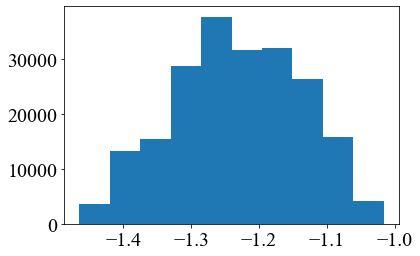

In [5]:
modelver = "cm+tidal"

incl = np.deg2rad(60.000001)
thet = np.deg2rad(0.000001)
muE0 = 0.68         #Center of mass proper motion east in mas/yr
muN0 = -1.23         #CM proper motion north	in mas/yr
vsys = 148.0          #CM radial velocity in km/s
m_M = 18.91

dist0 = (10**((m_M/5.0)+1)) / 1000.0      #distance in kpc to the galaxy center

rad0 = 1.00001
rotvel0 = 100.0

phi_tid = np.deg2rad(0.0)
theta_tid = np.deg2rad(89.99999)
v_tid = 0.0

mue, mun, rv = pmmodel(muE0, muN0, dist0, vsys, ra0, dec0, np.deg2rad(model['RA']), np.deg2rad(model['DEC']), \
                       incl, thet, rad0, rotvel0, phi_tid, theta_tid, v_tid)

mux, muy, mux_rel, muy_rel = plot_prep(np.deg2rad(model['RA']), np.deg2rad(model['DEC']), mue, mun, ra0, dec0, \
                                             muE0, muN0, dist0, vsys, incl, thet)


plt.clf()
plt.hist(muy)
plt.show()

try:
    model.add_column(mux, name='mux')
    model.add_column(muy, name='muy')
    model.add_column(mux_rel, name='mux_rel')
    model.add_column(muy_rel, name='muy_rel')
    
except ValueError:
    print("Already added those columns, need to restart kernel.")

<Figure size 432x288 with 0 Axes>

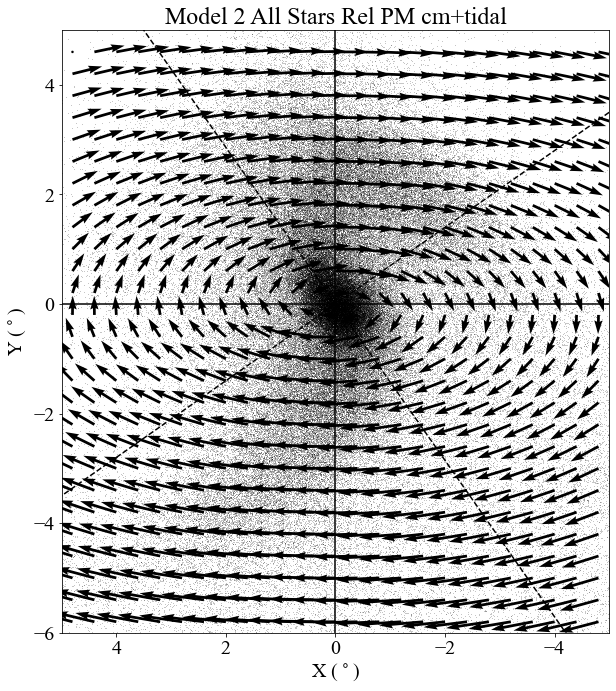

<Figure size 432x288 with 0 Axes>

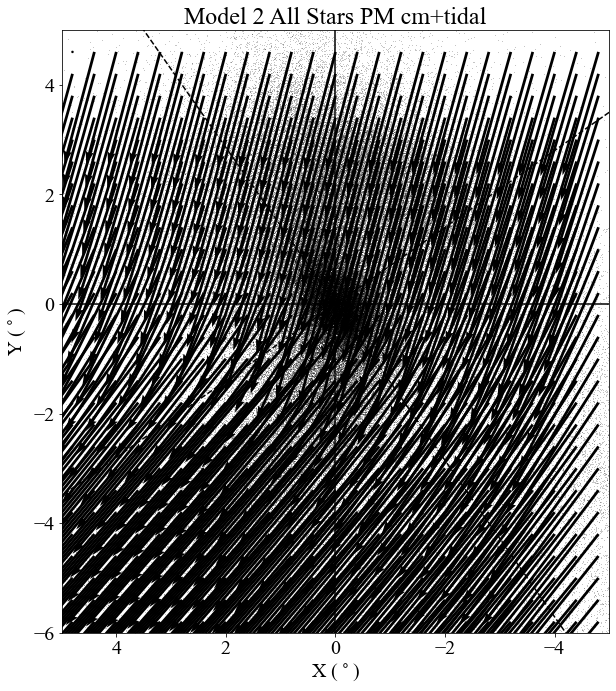

In [6]:
pm_rel_bins = vec_grid(model, xwidth, xmax, xmin, ywidth, ymax, ymin, 'x', 'y', 'mux_rel', 'muy_rel')

pmbinx, pmbiny, pmbinpmx, pmbinpmy = 0, 1, 2, 3

ocol = "black"

#### 
# Plot averaged residual vectors for all stars
####

visscale = 5.0

plt.clf()
fig, ax = plt.subplots(figsize=(10,10))

ax.scatter(model['x'], model['y'], s=2, lw=0, color="black", marker=".", alpha=0.3)
#version with no color
q1 = ax.quiver(pm_rel_bins[:,pmbinx], pm_rel_bins[:,pmbiny], \
                (-1.0*visscale*pm_rel_bins[:,pmbinpmx]), \
                (visscale*pm_rel_bins[:,pmbinpmy]), lw=2, \
                units="xy", scale=(visscale/2.0), color=ocol, \
                width=0.05)

# tidalxy = np.asarray([[0.0, 0.0]])
# tidalvxy = np.asarray([[0.43452, -0.20803]])

# q2 = ax.quiver(tidalxy[:,0], tidalxy[:,1], (-1.0*visscale*tidalvxy[:,0]), \
#                 (visscale*tidalvxy[:,1]), lw=0,  units="xy", \
#                 scale=(visscale/2.0), color=relc)


ax.plot(yaxis[:,0], yaxis[:,1], color="black")
ax.plot(xaxis[:,0], xaxis[:,1], color="black")

ax.plot(newyaxis[:,0], newyaxis[:,1], ls="--", color="black")
ax.plot(newxaxis[:,0], newxaxis[:,1], ls="--", color="black")

ax.set_xlabel(r'X ($^\circ$)')
ax.set_ylabel(r'Y ($^\circ$)')

ax.set_xlim(xmin, xmax)
ax.set_ylim(ymin, ymax)

ax.invert_xaxis()          
ax.set_aspect("equal")
ax.set_title("Model " + num + " All Stars Rel PM " + modelver)
plt.tight_layout()
plt.show()
fig.savefig("Plots/Model" + num + "_Testing/all_model_pm_rel_" + modelver + ".png", dpi=300, facecolor="white", edgecolor='none')



#### 
# Plot averaged full vectors for all stars
####

pm_bins = vec_grid(model, xwidth, xmax, xmin, ywidth, ymax, ymin, 'x', 'y', 'mux', 'muy')

visscale = 5.0

##

plt.clf()
fig, ax = plt.subplots(figsize=(10,10))

ax.scatter(model['x'], model['y'], s=2, lw=0, color="black", marker=".", alpha=0.3)
#version with no color
q1 = ax.quiver(pm_bins[:,pmbinx], pm_bins[:,pmbiny], \
                (-1.0*visscale*pm_bins[:,pmbinpmx]), \
                (visscale*pm_bins[:,pmbinpmy]), lw=2, \
                units="xy", scale=(visscale/2.0), color=ocol, \
                width=0.05)

# tidalxy = np.asarray([[0.0, 0.0]])
# tidalvxy = np.asarray([[0.43452, -0.20803]])

# q2 = ax.quiver(tidalxy[:,0], tidalxy[:,1], (-1.0*visscale*tidalvxy[:,0]), \
#                 (visscale*tidalvxy[:,1]), lw=0,  units="xy", \
#                 scale=(visscale/2.0), color=relc)


ax.plot(yaxis[:,0], yaxis[:,1], color="black")
ax.plot(xaxis[:,0], xaxis[:,1], color="black")

ax.plot(newyaxis[:,0], newyaxis[:,1], ls="--", color="black")
ax.plot(newxaxis[:,0], newxaxis[:,1], ls="--", color="black")

ax.set_xlabel(r'X ($^\circ$)')
ax.set_ylabel(r'Y ($^\circ$)')

ax.set_xlim(xmin, xmax)
ax.set_ylim(ymin, ymax)

ax.invert_xaxis()          
ax.set_aspect("equal")
ax.set_title("Model " + num + " All Stars PM " + modelver)
plt.tight_layout()
plt.show()
fig.savefig("Plots/Model" + num + "_Testing/all_model_pm_" + modelver + ".png", dpi=300, facecolor="white", edgecolor='none')